In [3]:
import numpy as np
import torch
import pandas as pd
import numpy as np

In [4]:
from matplotlib import pyplot as plt
plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

In [5]:
from tqdm.auto import tqdm

In [6]:
import kcmc
from kcmc.estimators import confounding_robust_estimator, hajek, ipw
from kcmc.experiment_policy_evaluation import run_policy_evaluation_experiment

# Binary Synthetic Data

In [7]:
from kcmc.data_binary import evaluate_policy, generate_data, estimate_p_t

In [8]:
beta_e_x = np.asarray([0, .75, -.5, 0, -1])

def toy_policy(X, T):
    n = X.shape[0]
    T = torch.as_tensor(T)
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    e_x = torch.exp(z) / (1 + torch.exp(z))
    return (1. - T) * e_x + T * (1. - e_x)

In [9]:
# Guessing kernel with approximate solution
Y, T, X, _, _, _ = generate_data(1000)
p_t = estimate_p_t(X, T)
_, w_guess = confounding_robust_estimator(
    Y, T, X, p_t, toy_policy, Gamma=1.5,
    hajek_const=True, tan_box_const=True, 
    return_w=True, normalize_p_t=True, 
)
e_guess = p_t * w_guess - 1
gp_kernel = kcmc.estimators.fit_gp_kernel(e_guess, T, X)
kernel = gp_kernel.k2

#### Define a trainable policy

In [10]:
def LR_policy(X, T, beta):
    n = X.shape[0]
    T = torch.as_tensor(T)
    X = np.concatenate([np.ones([n, 1]), X], axis=1)
    p = torch.sigmoid(torch.tensor(X) @ beta)
    return (1 - T) * p + T * (1 - p)

### Experiment of Policy Learning Curve

In [24]:
def update_base_method(**new_params):
    ret = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS.copy()
    ret.update(new_params)
    return ret

grid_methods = {
    'hard_KCMC': update_base_method(
        #hajek_const=True,
        #normalize_p_t=True,
        tan_box_const=True,
        kernel=kernel,
        kernel_const=True,
        hard_kernel_const=True,
        D=100,
    ),
}

grid_sample_size = np.linspace(50, 1000, 11).astype(int)
grid_D = [25, 50, 100]

In [15]:
import csv
import os.path
import numpy as np
from sklearn.gaussian_process.kernels import RBF
from kcmc.estimators import confounding_robust_estimator


EXAMPLE_PARAMS = kcmc.experiment_policy_evaluation.EXAMPLE_PARAMS

def run_policy_learning_experiment(
    log_file, params, data_type='synthetic binary', sample_size=500, n_seeds=1, seed0=0, n_steps=201, log_info="",
):
    assert data_type in ['synthetic binary', 'synthetic continuous', 'real binary']
    assert set(params.keys()) == set(EXAMPLE_PARAMS.keys())
    print(f"Policy learning with {log_info} (n={sample_size}, D={params['D']})...")
    pbar = tqdm(total=n_seeds * (n_steps + 10 * n_seeds))

    for seed in range(seed0, seed0 + n_seeds):
        Y, T, X, p_t = get_data(data_type, sample_size, seed)
        beta = torch.zeros(6, requires_grad=True, dtype=float)
        logistic_policy = lambda X, T: LR_policy(X, T, beta)
        optimizer = torch.optim.SGD(lr=1e-1, params=[beta])
        for i in range(n_steps):
            lower_bound = confounding_robust_estimator(Y, T, X, p_t, logistic_policy, **params)
            np.random.seed(0)
            (- lower_bound).backward()
            optimizer.step()
            optimizer.zero_grad()
            lower_bound = lower_bound.data.numpy()
            pbar.set_description(f"Seed: {seed},\tTrain lower bound: {lower_bound}")
            pbar.update(1)
            
        lower_bound = confounding_robust_estimator(Y, T, X, p_t, logistic_policy, **params).data.numpy()
        ground_truth = evaluate_policy(logistic_policy, n=100000).data.numpy()
        log_csv(log_file, data_type, 'logistic policy', lower_bound, ground_truth, params, sample_size, seed, log_info, i)
        
        for seed in range(seed0, seed0 + n_seeds):
            np.random.seed(seed)
            Y, T, X, _, _, _ = generate_data(5000)
            p_t = estimate_p_t(X, T)
            #params['D'] = 250
            params['hard_kernel_const'] = True
            # sample_size=5000
            ground_truth = evaluate_policy(logistic_policy, n=100000).data.numpy()
            test_lower_bound = confounding_robust_estimator(Y, T, X, p_t, logistic_policy, **params).data.numpy()
            p_t = estimate_p_t(X, T)
            log_csv(log_file, data_type, 'logistic policy', test_lower_bound, ground_truth, params, sample_size, seed, log_info+"_test", i)
            pbar.set_description(f"Seed: {seed},\tTest lower bound: {test_lower_bound}")
            pbar.update(10)
    pbar.close()
            
def get_data(data_type, sample_size, seed):
    if 'synthetic' in data_type:
        if 'binary' in data_type:
            from kcmc.data_binary import generate_data, evaluate_policy, estimate_p_t
        elif 'continuous' in data_type:
            from kcmc.data_continuous import generate_data, evaluate_policy, estimate_p_t
        else:
            raise ValueError
        np.random.seed(seed)
        Y, T, X, U, e_x, e_xu = generate_data(sample_size)
        p_t = estimate_p_t(X, T)
    elif 'real' in data_type:
        from kcmc.data_real import generate_data, estimate_p_t
        Y, T, X = generate_data()
        p_t = estimate_p_t(X, T)
    return Y, T, X, p_t

def log_csv(log_file, data_type, policy_name, lower_bound, ground_truth, params, sample_size, seed, log_info, step):
    if not os.path.exists(log_file):
        # make a column name
        columns = ['log_info', 'data_type', 'policy_name', 'sample_size', 'seed', 'step', 'lower_bound', 'ground_truth', *params.keys()]
        with open(log_file, 'a') as file:
            writer = csv.writer(file)
            writer.writerow(columns)
    # log data by appending to the csv file
    fields=[log_info, data_type, policy_name, sample_size, seed, step, lower_bound, ground_truth, *params.values()]
    with open(log_file, 'a') as file:
        writer = csv.writer(file)
        writer.writerow(fields)
                                      

In [16]:
log_file='logs/policy_learning_synthetic_binary_consistency.csv'

for n in reversed(grid_sample_size):
    for method_name, params in grid_methods.items():
        for D in reversed(grid_D):
            params['D'] = D
            run_policy_learning_experiment(
                log_file, params, data_type='synthetic binary', 
                n_seeds=10, sample_size=n, log_info=method_name
            )

Policy learning with hard_KCMC (n=1000, D=100)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=1000, D=50)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=1000, D=25)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=905, D=100)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=905, D=50)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=905, D=25)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=810, D=100)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=810, D=50)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=810, D=25)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=715, D=100)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=715, D=50)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=715, D=25)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=620, D=100)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=620, D=50)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=620, D=25)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=525, D=100)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=525, D=50)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=525, D=25)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=430, D=100)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=430, D=50)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=430, D=25)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=335, D=100)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=335, D=50)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=335, D=25)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=240, D=100)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=240, D=50)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=240, D=25)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=145, D=100)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=145, D=50)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=145, D=25)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=50, D=100)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=50, D=50)...


  0%|          | 0/3010 [00:00<?, ?it/s]

Policy learning with hard_KCMC (n=50, D=25)...


  0%|          | 0/3010 [00:00<?, ?it/s]

In [17]:
df = pd.read_csv('logs/policy_learning_synthetic_binary_consistency.csv')

In [18]:
df.head()

,log_info,data_type,policy_name,sample_size,seed,step,lower_bound,ground_truth,D,Gamma,...,rescale_kernel,normalize_p_t,f_divergence,hajek_const,kernel_const,quantile_const,regressor_const,tan_box_const,lr_box_const,f_const
0,hard_KCMC,synthetic binary,logistic policy,1000,0,200,4.272296,4.523217,100,1.5,...,False,False,total variation,False,True,False,False,True,False,False
1,hard_KCMC_test,synthetic binary,logistic policy,1000,0,200,4.411281,4.526997,100,1.5,...,False,False,total variation,False,True,False,False,True,False,False
2,hard_KCMC_test,synthetic binary,logistic policy,1000,1,200,4.388659,4.523919,100,1.5,...,False,False,total variation,False,True,False,False,True,False,False
3,hard_KCMC_test,synthetic binary,logistic policy,1000,2,200,4.365455,4.527047,100,1.5,...,False,False,total variation,False,True,False,False,True,False,False
4,hard_KCMC_test,synthetic binary,logistic policy,1000,3,200,4.411975,4.538065,100,1.5,...,False,False,total variation,False,True,False,False,True,False,False


In [19]:
#df = df.iloc[266:, :]

In [21]:
df.groupby(by=["log_info", "D", "sample_size"]).count()

data_type  policy_name  seed  step  \
log_info       D   sample_size                                       
hard_KCMC      25  50                  10           10    10    10   
                   145                 10           10    10    10   
                   240                 10           10    10    10   
                   335                 10           10    10    10   
                   430                 10           10    10    10   
...                                   ...          ...   ...   ...   
hard_KCMC_test 100 620                100          100   100   100   
                   715                100          100   100   100   
                   810                100          100   100   100   
                   905                100          100   100   100   
                   1000               100          100   100   100   

                                lower_bound  ground_truth  Gamma  gamma  \
log_info       D   sample_size                                            
hard_KCMC      25  50                    10            10     10     10   
                   145                   10            10     10     10   
                   240                   10            10     10     10   
                   335                   10            10     10     10   
                   430                   10            10     10     10   
...                                     ...           ...    ...    ...   
hard_KCMC_test 100 620                  100           100    100    100   
                   715                  100           100    100    100   
                   810                  100           100    100    100   
                   905                  100           100    100    100   
                   1000                 100           100    100    100   

                                alpha  sigma2  ...  rescale_kernel  \
log_info       D   sample_size                 ...                   
hard_KCMC      25  50              10      10  ...              10   
                   145             10      10  ...              10   
                   240             10      10  ...              10   
                   335             10      10  ...              10   
                   430             10      10  ...              10   
...                               ...     ...  ...             ...   
hard_KCMC_test 100 620            100     100  ...             100   
                   715            100     100  ...             100   
                   810            100     100  ...             100   
                   905            100     100  ...             100   
                   1000           100     100  ...             100   

                                normalize_p_t  f_divergence  hajek_const  \
log_info       D   sample_size                                             
hard_KCMC      25  50                      10            10           10   
                   145                     10            10           10   
                   240                     10            10           10   
                   335                     10            10           10   
                   430                     10            10           10   
...                                       ...           ...          ...   
hard_KCMC_test 100 620                    100           100          100   
                   715                    100           100          100   
                   810                    100           100          100   
                   905                    100           100          100   
                   1000                   100           100          100   

                                kernel_const  quantile_const  regressor_const  \
log_info       D   sample_size                                                  
hard_KCMC      25  50                     10              10               10   
  

In [22]:
df_grouped = df.groupby(by=['log_info', 'D', 'sample_size'])['lower_bound', 'ground_truth']
values_mean = df_grouped.mean()
values_std = df_grouped.std()

/tmp/ipykernel_2213909/3534750207.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df.groupby(by=['log_info', 'D', 'sample_size'])['lower_bound', 'ground_truth']


In [25]:
values_mean

lower_bound  ground_truth
log_info       D   sample_size                           
hard_KCMC      25  50              5.241372      4.299917
                   145             5.033469      4.415599
                   240             4.576164      4.432462
                   335             4.401920      4.447870
                   430             4.677564      4.409947
...                                     ...           ...
hard_KCMC_test 100 620             4.282960      4.487037
                   715             4.333956      4.489846
                   810             4.359333      4.534271
                   905             4.370411      4.510389
                   1000            4.315530      4.504390

[66 rows x 2 columns]

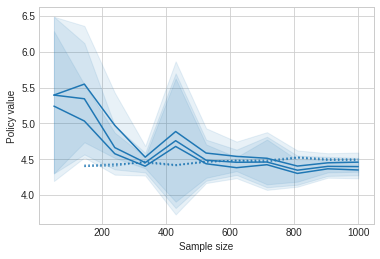

In [26]:
colors = {method: tab10((0.5 + i) / 10) for i, method in enumerate(grid_methods.keys())}
colors["ZSB"] = tab10((0.5 + 3) / 10)
legend_targets = []
legend_tags = ["low-rank GP KCMC ($D=100$)", "low-rank hard KCMC ($D=100$)", "ZSB"]

for D in grid_D:
    for method_name in grid_methods.keys():
        lower = np.array([values_mean.loc[(method_name, D, n)]['lower_bound'] for n in grid_sample_size])
        dlower = np.array([values_std.loc[(method_name, D, n)]['lower_bound'] for n in grid_sample_size])
        test_lower = np.array([values_std.loc[(method_name + "_test", D, n)]['lower_bound'] for n in grid_sample_size])
        gt = np.array([values_mean.loc[(method_name, D, n)]['ground_truth'] for n in grid_sample_size])
        # dtest_lower = values_std.loc[(method + '_test', max(steps))]['lower_bound']
        c = colors[method_name]
        lower_line = plt.plot(grid_sample_size, lower, c=c)[0]
        lower_band = plt.fill_between(grid_sample_size, lower + dlower, lower - dlower, color=c, alpha=0.1)
        #test_lower = plt.plot(grid_sample_size, test_lower, c=c)[0]
        shifted_slice = slice(1, len(grid_sample_size)) if 'hard' in method_name else slice(len(grid_sample_size))
        gt_line = plt.plot(grid_sample_size[shifted_slice], gt[shifted_slice], ':', c=c, alpha=0.7)[0]
        legend_targets.append((lower_line, lower_band))

#plt.legend(legend_targets, legend_tags)
plt.xlabel(r"Sample size")
plt.ylabel(r"Policy value")
plt.savefig('logs/policy_learning_synthetic_binary_curve.pdf')

In [80]:
df[df.step==200].head()

,log_info,data_type,policy_name,sample_size,seed,step,lower_bound,ground_truth,D,lambd,...,hard_kernel_const,normalize_p_t,f_divergence,hajek_const,kernel_const,quantile_const,regressor_const,tan_box_const,lr_box_const,f_const
265,ZSB,synthetic binary,logistic policy,500,0,200,4.705517,4.453796,200,1.5,...,False,True,total variation,True,False,False,False,True,False,False
466,ZSB,synthetic binary,logistic policy,500,0,200,4.705517,4.453796,250,1.5,...,True,True,total variation,True,False,False,False,True,False,False
467,ZSB_test,synthetic binary,logistic policy,500,0,200,4.255855,-1.000000,250,1.5,...,True,True,total variation,True,False,False,False,True,False,False
468,ZSB_test,synthetic binary,logistic policy,500,1,200,4.187823,-1.000000,250,1.5,...,True,True,total variation,True,False,False,False,True,False,False
469,ZSB_test,synthetic binary,logistic policy,500,2,200,4.074019,-1.000000,250,1.5,...,True,True,total variation,True,False,False,False,True,False,False


#### The interpretation of the above plot:
- Since the upper/lower bound's tightness is independent of the sample size by definition, the width of interval should not change significantly for different sample size
- However, the 

#### Best Policy

In [ ]:
train_steps = 101
beta_best = torch.zeros(6, requires_grad=True, dtype=float)
best_policy = lambda X, T: LR_policy(X, T, beta_best)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_best])
pbar = tqdm(range(train_steps))
for i in pbar:
    value = evaluate_policy(best_policy, n=100000)
    (- value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {value}")

  0%|          | 0/101 [00:00<?, ?it/s]

### Just run min-max optimzation

In [ ]:
def evaluate_confounding_robust_hajek(policy):
    est = confounding_robust_estimator(
        Y, T, X, p_t, policy, 
        lambd=1.5, hajek_const=True, tan_box_const=True,
    )
    return est

In [ ]:
def evaluate_confounding_robust_kernel(policy):
    est = confounding_robust_estimator(
        Y, T, X, p_t, policy, 
        D=200, lambd=1.5, alpha=0.05, 
        sigma2=sigma2, kernel=kernel,
        kernel_const=True,
        tan_box_const=True,
    )
    return est

In [ ]:
# Hajek policy min-max value
train_steps = 101
beta_hajek = torch.zeros(6, requires_grad=True, dtype=float)
hajek_policy = lambda X, T: LR_policy(X, T, beta_hajek)
optimizer = torch.optim.SGD(lr=1e-1, params=[beta_hajek])
pbar = tqdm(range(train_steps))
for i in pbar:
    hajek_value = evaluate_confounding_robust_hajek(hajek_policy)
    (- hajek_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {hajek_value}")

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
evaluate_policy(hajek_policy, n=100000)

tensor(4.4034, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
evaluate_confounding_robust_kernel(hajek_policy)

tensor(4.0741, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
# Kernel policy min-max value
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X, T: LR_policy(X, T, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
pbar = tqdm(range(train_steps))
for i in pbar:
    kernel_value = evaluate_confounding_robust_kernel(kernel_policy)
    (- kernel_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {kernel_value}")

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.6240, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
evaluate_confounding_robust_kernel(kernel_policy)

tensor(4.4347, dtype=torch.float64, grad_fn=<MeanBackward0>)